**Импортируем необходимые библиотеки**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-whitegrid")

In [ ]:
# Загрузка датасета
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
print(f"Размерность: {dataset.shape}")
display(dataset.head())

In [ ]:
print("Пропущенные значения:")
print(dataset.isnull().sum())
display(dataset.describe())

Пропущенных значений нет

Посмотрим несколько примеров сигналов из датасета 

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(dataset.iloc[i].values, label=f"Сигнал {i}", alpha=0.7)
plt.title("Примеры сигналов")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.legend()
plt.tight_layout()
plt.show()

**Выделение сигнала**

Для начала необходимо выделить часть сигнала на основе которой потом можно будет посчитать физические признаки.


Значение сигмы возьмем за 3 в соответствие с методическими указаниями и рассмотрим первые 50 точек, из предыдущего рисунка видно, что это относительно спокойная часть, где виден только фоновый шум.

In [ ]:
def extract_signal(row, pre_window=50, sigma_level=3):
    row = np.array(row)
    baseline = row[:pre_window].mean()
    noise_std = row[:pre_window].std()
    peak_idx = np.argmin(row)
    stop_idx = peak_idx
    thresh = baseline - sigma_level * noise_std
    for i in range(peak_idx, len(row)):
        if row[i] > thresh:
            stop_idx = i
            break
    signal = row[peak_idx:stop_idx]
    return signal, baseline, peak_idx, stop_idx

**Функция вычисления новых признаков**

Теперь необходимо преобразовать неинформативные сигналы в набор признаков, описывающих физику.


Для дальнейшей работы нам понадобятся amp (размах), area (площадь под сигналом), tau (показатель затухания), ratio (отношение площади к амплитуде), duration (), коэффициент psd.

In [ ]:
def calc_features_classmate(row, pre_window=50, sigma_level=3, short_window=10):
    signal, baseline, peak_idx, stop_idx = extract_signal(row, pre_window, sigma_level)
    if len(signal) == 0:
        return pd.Series([np.nan]*6, index=["amp","area","tau","ratio","duration","psd"])
    
    amp = baseline - signal.min()
    
    area = np.sum(baseline - signal)
    
    duration = len(signal)
    
    try:
        x = np.arange(len(signal))
        popt, _ = curve_fit(lambda x,a,t,c: a*np.exp(-x/t)+c, x, signal, p0=(amp,8,baseline), maxfev=3000)
        tau = abs(popt[1])
    except:
        tau = np.nan
    
    short = np.sum(baseline - signal[:short_window])
    psd = (area - short)/area if area>0 else np.nan
    ratio = area/amp if amp>0 else np.nan
    return pd.Series([amp,area,tau,ratio,duration,psd],
                     index=["amp","area","tau","ratio","duration","psd"])

#Новые признаки
features_df = dataset.apply(calc_features_classmate, axis=1)
display(features_df.describe())

In [ ]:
plt.figure(figsize=(8,7))
plt.scatter(features_df["amp"], features_df["area"], s=10, alpha=0.8)
plt.xlabel("amp")
plt.ylabel("area")
plt.title("area-amp")
plt.grid(True)
plt.tight_layout()
plt.show()

Визуализация `area-amp` позволяет уже на этом этапе оценить, что существуют отделимые группы сигналов. График по форме соответствует тому, что представлен в методических указаниях. Это подтверждает физическую обоснованность будущей кластеризации при помощи алгоритмов машинного обучения.

**Решение с использованием алгоритмов класстеризации**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

X = features_df.dropna().copy()
feat_cols = ["amp", "area", "tau", "ratio", "duration", "psd"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[feat_cols])

**Кластеризация**

Воспользуемся KMeans и GMM, сравним результаты и на основе метрик выберем лучшую модель:

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=30)
k_labels = kmeans.fit_predict(X_scaled)
X["KMeans"] = k_labels

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
g_labels = gmm.fit_predict(X_scaled)
X["GMM"] = g_labels

**Визуализация и метрики**

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=X, x="area", y="amp", hue="KMeans", palette="Set2",
    s=20, alpha=0.6
)
plt.title("KMeans")
plt.xlabel("area")
plt.ylabel("amp")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=X, x="area", y="amp", hue="GMM", palette="Set1",
    s=20, alpha=0.6
)
plt.title("GMM")
plt.xlabel("area")
plt.ylabel("amp")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

sil_k = silhouette_score(X_scaled, k_labels)
sil_g = silhouette_score(X_scaled, g_labels)
ch_k = calinski_harabasz_score(X_scaled, k_labels)
ch_g = calinski_harabasz_score(X_scaled, g_labels)

print(f"KMeans:   Silhouette = {sil_k:.3f}, Calinski-Harabasz = {ch_k:.1f}")
print(f"GMM:      Silhouette = {sil_g:.3f}, Calinski-Harabasz = {ch_g:.1f}")

С визуальной точки зрения алгоритм KMeans справился лучше, что подтверждается метриками. Выберем его для дальнейшей корректировки и итогового сабмишена.

**С целью соответствия физическому смыслу подкорректируем метки**

In [ ]:
X["KMeans_fixed"] = X["KMeans"].replace({1: 2, 2: 1})
X["KMeans_final"] = X["KMeans_fixed"].replace({0: 1, 1: 0})

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=X, x="area", y="amp", hue="KMeans_final", palette="Set2",
    s=20, alpha=0.6
)
plt.title("KMeans с учетом физического смысла")
plt.xlabel("area")
plt.ylabel("amp")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

**Сабмишен**

In [ ]:
import pandas as pd

submission = pd.DataFrame({
    "index": X.index.astype(int),
    "cluster": X["KMeans_final"].astype(int)
})

submission.to_csv("submission.csv", index=False)

KAGGLE - 0.75842

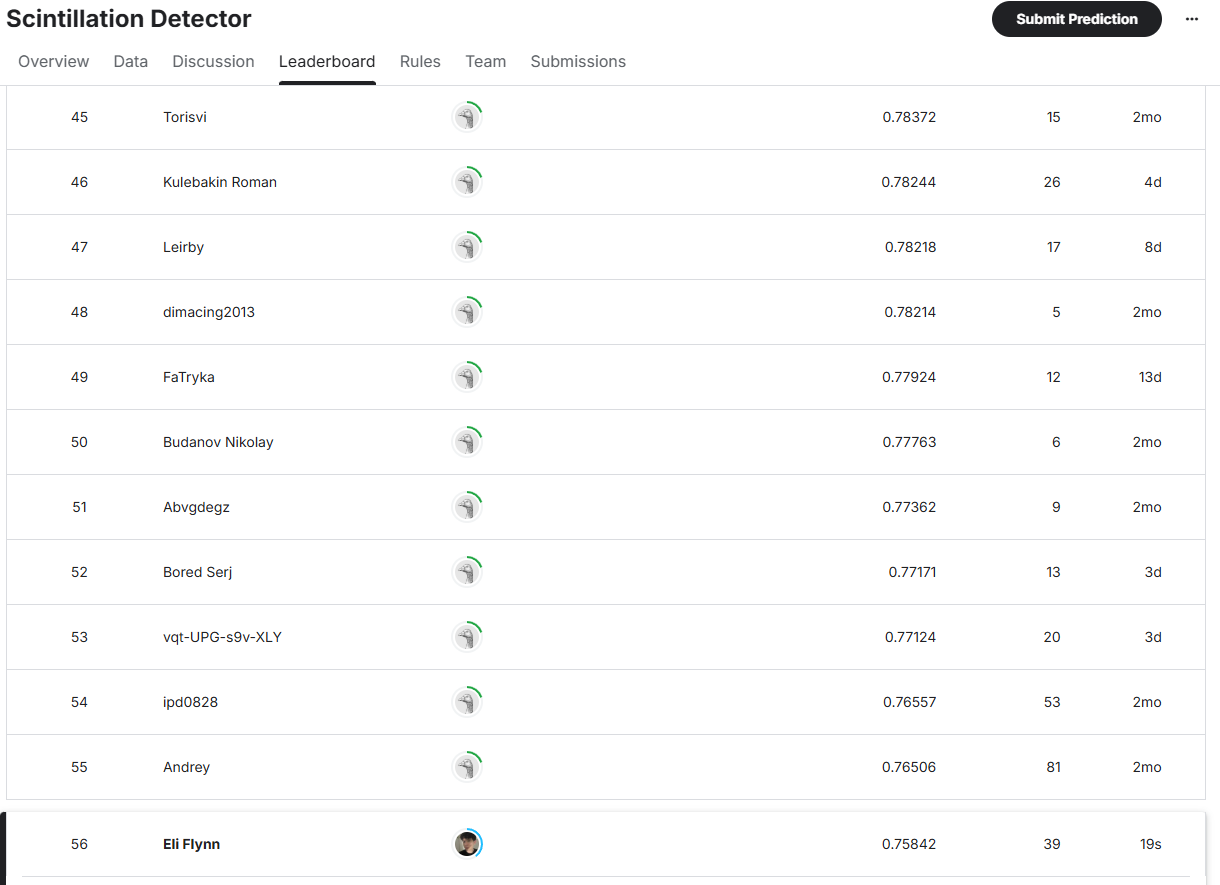